# Classification and Clustering

In [108]:
# ! pip install pyamg #pyamg for efficient solving for spectral clustering

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import collections, re, string, glob, collections, pickle, os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import dump_svmlight_file, load_svmlight_file
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cluster import SpectralClustering
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MaxAbsScaler
from sklearn import metrics
from scipy.sparse import hstack
from imblearn import over_sampling

import utils_vectoriser

In [ ]:
## TO DO
# 4. lemma subset by POS tags - probably NMF
# 3. imbalearn upsampling 
# 4. check 

# Probably less useful
# 5. tuning TFIDF levels 
# 1. ngrams - since we are working at sentence-based level (instead of doc-based)

## Bells and whistles
# 1. pipeline to save models, featuresets and results 

### Initial results
|Run   	|Classifier   	|Featureset   	|train acc   	|test acc   	|alpha/C   	|
|---	|---	|---	|---	|---	|---	|
|1   	|M_NB   	|subj, lemmas, parse_VP, book_ners   	|98.67   	|28.71   	|0   	|
|2   	|LogReg, OVR, L2   	|subj, lemmas, parse_VP, book_ners   	|0.84   	|0.38   	|1   	|
|3   	|LogReg, OVR, L2, with TSVD5000   	|subj, lemmas, parse_VP, book_ners   	|0.77   	|0.36   	|1   	|
|4   	|LogReg, multin, L1   	|subj, lemmas, parse_VP, book_ners   	|very poor   	|very poor   	|0.5   	|
|4   	|LogReg, OVR, L1, with MaxAbsScaler   	|subj, lemmas, parse_VP, book_ners   	|0.99  	|0.39   	|1   	|
|5   	|LogRegCV, OVR, L2   	|subj, lemmas, parse_VP, book_ners   	|   	|   	|   	|


The cross_val_score on the train set using Logistic Regression is not good at all (feature set is with entire set of lemmas. Propose to add the subset of the lemmas based on their POS tags. 

### 1. Create training and evaluation sets

#### 1a. Corollary: Computing a subjectivity score

We have access to a set of [subjectivity classification for about 8,200 English words](https://gitlab.inria.fr/mastertal/UE803/blob/master/data/l10_data/subjectivity_clues_hltemnlp05/subjclueslen1-HLTEMNLP05.README). We hypothesize that an average subjectivity score can help to further distinguish between authors. 
Our datapoints are however single sentences from at least 3 books of an author, and it is not sensible to compute the score for every sentence as there can be significant variability for such a score between an author's ouevre. Instead we compute the score based on the entire set of the author's sentences admitted into our corpus. 

We hypothesize that ideally, it will be better to compute the score based on each set of sentences from a single book of one author. This could provide a better predictor of an author's identity, by capturing a certain understanding about the subjectivity, and variability of the subjectivity, of his/her body of work. 

In [57]:
with open("../2_Preprocessing/supportdata/SubjectivityClues/data_l10_data_subjectivity_clues_hltemnlp05_subjclueslen1-HLTEMNLP05.tff", 
          "r") as file:
    subjectivityclues_all = file.read()
    
subj_scores = [1 if i == "type=weaksubj" else 2 for i in re.findall(r"type=[a-z]+", subjectivityclues_all)]
# encoding 1 and 2, since the classes are ordinal - "weaksubj" and "strongsubj"
subj_words = [i.lstrip("word1=") for i in re.findall(r"word1=[a-z]+", subjectivityclues_all)]
subj_pos = [i.lstrip("pos1=") for i in re.findall(r"pos1=[a-z]+", subjectivityclues_all)]
# side note on pos and stemming: the dataset does not use the UD POS tags, so we cannot map the tokens more precisely
# based on the POS tag we have for the corpus tokens. also, the Wilson et al 2005 data include whether the words were 
# stemmed (i.e. usable on our lemmas sets), but it numbers only 1620, out of 8222 words, or less than 20%. so we 
# should compute our subjectivity score using our tokens set instead of lemmas

subj_trip_info = [i for i in zip(subj_scores, subj_pos)]
__dictcombined = {subj_words[index]: subj_trip_info[index] for index in range(len(subj_words))}
# there are 5 words that have zero length and it is throwing an error in the filtering.
# also pointless to have a score for an empty string in the computation of the subjectivity score. 
# it might have come about at the re.findall level, but the empty word issue still persists
# after adding A-Z and 1-9 to the search pattern. 
__dictcombined_filter = {i: __dictcombined[i] for i in __dictcombined if len(i) > 0}

# sort into a dictionary to speed search time 
subj_dict = {}
for letter in string.ascii_lowercase: 
    subj_dict[letter] = {key:__dictcombined_filter[key] for key in __dictcombined_filter if key[0] == letter}
    

In [58]:
def get_subjectivity(spacysentdoc, subj_dict):
    '''given a spacysentdoc, or a np array of strings (tokens of a sentence), returns the subjectivity
    score for the sentence. The score is the sum of the score for tokens that can be 
    found in the http://crr.ugent.be/archives/1330 dataset. 
    Inputs: spacysentdoc
    Outputs: a tuple containing the function name and the result. result is an integer rounded to 3 dp 
    and converted to a string
    ''' 
    if type(spacysentdoc) == np.ndarray: 
        s_score = 0
        for sentence in spacysentdoc: 
            for token in sentence:
                try:
                    # using first letter of token, go to sub-dict of subj_dict
                    # if the token is one of the values of the sub-dict
                    # retrive the subjectivity score
                    if token in subj_dict[token[0]].keys():
                        s_score += int(subj_dict[token[0]][token][0])
                except: 
                    pass
        # the score is averaged across the number of tokens across the entire corpus/doc
        # it gives an indication of the usage of subjectivity words in writing style
        return "subjectivity", round(s_score/len(spacysentdoc), 3)
    else: 
        # condition for code extension to cover spacysentdoc (for alignment to insert into utils_tokeniser.py)
        pass
    

#### 1b. Importing pickled DFs, train-test split

__General approach__

1. iteratively load author pickled dfs, filter out sentences that are less than 10 tokens long (between the 25th and 50th percentile for sentence length across the entire corpus of all authors)
    - (since our dataset is built on one sentence per author, we drop sentences to avoid the possibility of an extremely sparse matrix. the short sentences would provide limited linguistics indicators (expressed through word freqency counts, ) to distinguish between authors. 
    - plus we already have sent_length and a high-level overview of a sentence's constituency structure as features
    - add author wiki abstract NERs
2. cut into train test split on each load (to ensure each author is evenly represented in the train and test sets)
3. concat train at end, concat test at end
4. fit tfidf on train (so as not to leak test data into train), transform on train and test
5. cut into sets of features
6. export to svm light 

__Data integrity checkpoint__

We could not complete preprocessing for 3 authors admitted into the corpus by Phase 1. An issue with the contents of their sentences is causing the constituency parser to break. 

In [59]:
##### Preliminaries #####
# 0. grab all the pickled df files
df_filenames = glob.glob("../2_Preprocessing/processeddata/df_pickles/*.pickle")
len(df_filenames)

# 1a. lists for collecting all the df objects to be generated for pd.concat - speediest approach 
# https://stackoverflow.com/questions/10715965/add-one-row-to-pandas-dataframe/24913075#24913075
dfs_list_train = [] 
dfs_list_test = []


# 1b. store author-label mapping
label2auth_map = {}
auth2label_map = {}


##### Processing #####
# 2. generate the master DF
label_counter = 1
for filename in df_filenames: 
    __ = pd.read_pickle(filename)
     
    authornum = __["authornum"][0]                             # get the authornum for this df   
                                
    label2auth_map[label_counter] = authornum                  # switch the authornum to int, store the mapping
    auth2label_map[authornum] = label_counter
    __["authornum"] = label_counter
    
    __ = __[__["sent_length"]>10]                               # filter out short sentences
    __["concreteness"] = __["concreteness"].astype(float)       # we set the concreteness score as a string 
                                                                # to run the process_one_author functions easily
                                                                # switch back to int here
    # get the subjectivity score for the author. 
    s_score = get_subjectivity(__["tokens"].values,subj_dict)[1]
    # add as a new column to this df
    __["subjectivity"]=s_score
    

    # train test split 
    __train, __test = train_test_split(__, test_size=0.20)
    dfs_list_train.append(__train)
    dfs_list_test.append(__test)
    
    label_counter += 1
    
allauthor_df_train = pd.concat(dfs_list_train, axis=0)
allauthor_df_test = pd.concat(dfs_list_test, axis=0)
allauthor_df_train.reset_index(drop= True, inplace=True)
allauthor_df_test.reset_index(drop= True, inplace=True)

print("train size: {}, test size: {}".format(allauthor_df_train.shape, allauthor_df_test.shape))

train size: (13837, 33), test size: (3518, 33)


In [60]:
# overview stats
allauthor_df_test.describe()

,authornum,concreteness,parse_NP,parse_S,parse_VP,pos_ADJ,pos_ADP,pos_ADV,pos_AUX,pos_CCONJ,...,pos_PRON,pos_PROPN,pos_PUNCT,pos_SCONJ,pos_SPACE,pos_SYM,pos_VERB,pos_X,sent_length,subjectivity
count,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000,3518.0,3518.000000,...,3518.000000,3518.000000,3518.000000,3518.0,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000,3518.000000
mean,57.490335,-0.195864,9.518476,3.601762,5.398238,2.891131,3.665151,1.860432,0.0,1.189028,...,1.882888,1.139284,4.046049,0.0,0.382604,0.006538,4.957362,0.012791,26.901933,5.833819
std,33.208405,6.125332,6.876015,2.461825,3.792045,2.622994,2.939033,1.761632,0.0,1.369194,...,1.841282,2.080943,3.175939,0.0,1.394067,0.124882,3.349664,0.175581,16.963702,1.710686
min,1.000000,-57.560000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,11.000000,2.491000
25%,28.000000,-3.537500,5.000000,2.000000,3.000000,1.000000,2.000000,1.000000,0.0,0.000000,...,1.000000,0.000000,2.000000,0.0,0.000000,0.000000,3.000000,0.000000,15.000000,4.379000
50%,58.000000,-0.030000,8.000000,3.000000,5.000000,2.000000,3.000000,1.000000,0.0,1.000000,...,1.000000,0.000000,3.000000,0.0,0.000000,0.000000,4.000000,0.000000,22.000000,5.764000
75%,86.000000,3.457500,12.000000,5.000000,7.000000,4.000000,5.000000,3.000000,0.0,2.000000,...,3.000000,2.000000,5.000000,0.0,0.000000,0.000000,6.000000,0.000000,33.000000,6.790000
max,115.000000,37.430000,112.000000,24.000000,33.000000,39.000000,30.000000,15.000000,0.0,12.000000,...,22.000000,40.000000,39.000000,0.0,26.000000,5.000000,35.000000,5.000000,202.000000,11.402000


In [61]:
# check object types - ints/floats, categoricals etc
allauthor_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3518 entries, 0 to 3517
Data columns (total 33 columns):
authornum       3518 non-null int64
concreteness    3518 non-null float64
lemmas          3518 non-null object
ne_dates        3518 non-null object
ne_persons      3518 non-null object
ne_places       3518 non-null object
parse_NP        3518 non-null int64
parse_S         3518 non-null int64
parse_VP        3518 non-null int64
pos_ADJ         3518 non-null int64
pos_ADP         3518 non-null int64
pos_ADV         3518 non-null int64
pos_AUX         3518 non-null int64
pos_CCONJ       3518 non-null int64
pos_CONJ        3518 non-null int64
pos_DET         3518 non-null int64
pos_INTJ        3518 non-null int64
pos_NOUN        3518 non-null int64
pos_NUM         3518 non-null int64
pos_PART        3518 non-null int64
pos_PRON        3518 non-null int64
pos_PROPN       3518 non-null int64
pos_PUNCT       3518 non-null int64
pos_SCONJ       3518 non-null int64
pos_SPACE       3518 no

#### 1c. Exploring the dataset

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


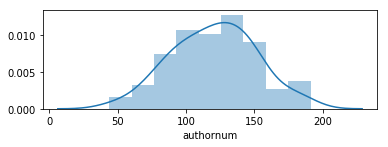

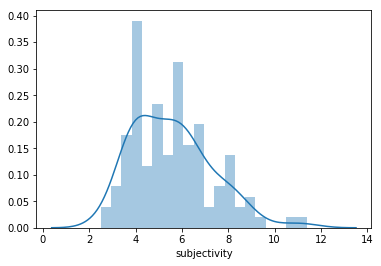

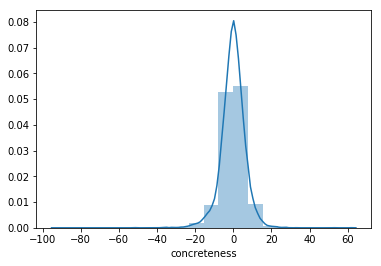

In [62]:
plt.subplot(2, 1, 2)
# let's take a look at the population distribution, to see if we need to finetune the corpus or augment datapoints
sns.distplot(allauthor_df_train.groupby("authornum")["authornum"].count())
plt.show()
# distribution of mean subjectivity score for each author's sentences  
sns.distplot(allauthor_df_train.groupby(["authornum","subjectivity"])["subjectivity"].mean(), bins=20)
plt.show()
# distribution of mean concreteness score for each author's sentences  
sns.distplot(allauthor_df_train.groupby(["authornum","concreteness"])["concreteness"].mean(), bins=20)
plt.show()

#### 1d. Vectorising lemmas and NERs

Our custom vectoriser in utils_vectoriser.py is not appropriate for this task. It implements [tf-max]( https://nlp.stanford.edu/IR-book/html/htmledition/maximum-tf-normalization-1.html) which is useful when working with a set that has document level data. Our current tf-max code set-up is not useful for our featureset structure here (we have no way to normalise over the docset (a book of an author's)). Instead, we use sklearn's TfidTransformer with DictVectoriser, since we already have a set of tokens and lemmas from our earlier custom preprocessing. 

In [ ]:
__features = {"lemmas": 
                  {"train": allauthor_df_train["lemmas"],
                    "test": allauthor_df_test["lemmas"],},
              "namedentities": 
                  {"train": allauthor_df_train['ne_dates']+allauthor_df_train['ne_places'],
                   "test": allauthor_df_test['ne_dates']+allauthor_df_test['ne_places'],}, }
                # add the ne_dates and ne_places columns for the vectoriser to manage sparsity. leave out 
                # persons for now, it is possible person names can significantly identify authors (except 
                # perhaps authors) 
                          
for feat in __features:
    # train data - generate DictCounts
    token_Counters_train = []
    for row in __features[feat]["train"].index:
        token_Counters_train.append(collections.Counter(__features[feat]["train"][row]))
    
    # test data - generate DictCounts
    token_Counters_test = []
    for row in __features[feat]["test"].index:
        token_Counters_test.append(collections.Counter(__features[feat]["test"][row]))
    
    # transforming test set based on the train set fit 
    # pass the DictCounts into DictVectorizer() 
    Dvectoriser = DictVectorizer()
    Dvect_result_train = Dvectoriser.fit_transform(token_Counters_train)
    Dvect_result_test = Dvectoriser.transform(token_Counters_test)

    Ttransformer = TfidfTransformer()
    Ttrans_results_train = Ttransformer.fit_transform(Dvect_result_train)
    Ttrans_results_test = Ttransformer.transform(Dvect_result_test)
    
    # write to SVM
    dump_svmlight_file(Ttrans_results_train, allauthor_df_train["authornum"], "data/train_"+feat+".svmlight")
    dump_svmlight_file(Ttrans_results_test, allauthor_df_test["authornum"], "data/test_"+feat+".svmlight")

In [ ]:
__other_features=['concreteness', 'subjectivity', "parse_VP"]
for feat in __other_features:
    # .reshapes since we are working with single feature sets each time 
    dump_svmlight_file(allauthor_df_train[feat].values.reshape(-1,1),
                       allauthor_df_train["authornum"], "data/train_"+feat+".svmlight")
    dump_svmlight_file(allauthor_df_test[feat].values.reshape(-1,1), 
                       allauthor_df_test["authornum"], "data/test_"+feat+".svmlight")        

In [ ]:
allauthor_df_train.columns

### 2. Large multiclass classification 

In [4]:
def load_data(data_path = "./data", features='lemmas'):
    '''
    '''
    X_train, y_train = load_svmlight_file( data_path+'/train_'+features+".svmlight" ) 
    X_test, y_test = load_svmlight_file( data_path+'/test_'+features+".svmlight", n_features=X_train.shape[1] ) 
    # shape of test shouldn't matter here since we enforced it at the vectorising step above
    
    return X_train, y_train, X_test, y_test

In [5]:
def stack( A, B ):
    return hstack( [A,B] )

X_tr_lemmas, y_train, X_te_lemmas, y_test = load_data( "./data", features='lemmas')
X_tr_concreteness, y_train, X_te_concreteness, y_test = load_data( "./data", features='concreteness')
X_tr_namedentities, y_train, X_te_namedentities, y_test = load_data( "./data", features='namedentities')
X_tr_parse_VP, y_train, X_te_parse_VP, y_test = load_data( "./data", features='parse_VP')
X_tr_subjectivity, y_train, X_te_subjectivity, y_test = load_data( "./data", features='subjectivity')

X_train = hstack( [X_tr_subjectivity, X_tr_lemmas,X_tr_namedentities, X_tr_parse_VP] )
X_test = hstack( [X_te_subjectivity, X_te_lemmas, X_te_namedentities, X_te_parse_VP] )

In [6]:
X_train.shape

(13837, 26502)

In [7]:
X_test.shape

(3518, 26502)

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


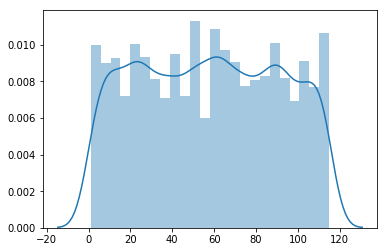

In [8]:
# The distribution of lables in the train set is a little uneven - we could try SMOTE upsampling (since we don't have 
# a very large dataset, so downsampling could worsen the learning)
sns.distplot(y_train)

__A. Dimensionality reduction to explore the characteristics of the data.__

We have a very sparse matrix of about 25,000 features. This is confusing the learning for the classifier, let's reduce dimensions to 5000, instead of 25,000, to see it's impact.  

In [12]:
# scale with MaxAbsScaler, to retain sparsity strcuture. Hopefully it will speed up computation. Would allow us to include 
# concreteness score (which has negative values) in the featureset, but need to investigate (i) sensibility of our 
# earlier centering of the concreteness score about -2.5 and 2.5. And if so, does MaxAbsScale entirely negate that? 

mas = MaxAbsScaler()
mas.fit(X_train)
X_train_SS = mas.transform(X_train)
X_test_SS = mas.transform(X_test)

In [ ]:
for n_components in [5,1000, 5000]:
    TSVD_model = TruncatedSVD(n_components=n_components, random_state=1,)
    X_train_TSVD_model = TSVD_model.fit(X_train)
    print("The explained variance for PCA with {} is {}".format(n_components, sum(TSVD_model.explained_variance_)))

In [ ]:
X_train_TSVD=X_train_TSVD_model.transform(X_train)
X_test_TSVD=X_train_TSVD_model.transform(X_test)

__A1. Results for [X_tr_subjectivity, X_tr_lemmas,X_tr_namedentities, X_tr_parse_VP]__

The explained variance for TruncatedSVD with 5 is 17.62470506672777

The explained variance for TruncatedSVD with 1000 is 18.178797730372374

The explained variance for TruncatedSVD with 5000 is 18.585553228841114


__B. Attempt at NMF to ensure non-negative values (which PCA allows)__

Post-PCA, our train set contains negative values and MultinomialNB does not accept that (although, fine for LogReg since it's a linear model). 

In [ ]:
n_components = 5000
nmf_model = NMF(n_components=n_components, init="nndsvdar", random_state=1, beta_loss="frobenius",
          alpha=.5, l1_ratio=.5, ) 
# We hypothesise that there are a lot of unnnecessary features, so we start by setting 
# a higher alpha for stronger regularisation (drive the weight of the unnecessary features to zero).
# We experiment with a 0.5 L1-L2 regularisation ratio. 
# nndsvdar for faster computation: too little RAM on our PCs :(

X_train_NMF = nmf_model.fit_transform(X_train)
X_test_NMF = nmf_model.transform(X_test)

#### 2a. Preliminaries: LogReg baseline model

In [50]:
logmodel= LogisticRegression()
logmodel.fit(X_train_SS, y_train,)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [14]:
print("train acc:", metrics.accuracy_score( y_train, logmodel.predict(X_train_SS) ))

train acc: 0.9904603599046036


In [15]:
print("test acc:", metrics.accuracy_score( y_test, logmodel.predict(X_test_SS) ))

test acc: 0.39511085844229676


In [52]:
cross_val_score(logmodel, X_train_SS, y_train)

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


array([0.35103181, 0.34049013, 0.34280717])

#### 2b. Classification models

In [41]:
def train_clf( X, y, classifier='m_nb', tune_param = 1.0 ):
    if classifier== 'm_nb':
        classifier = MultinomialNB(alpha=tune_param, fit_prior=True, class_prior=None) 
        # Train 
        classifier.fit( X, y )
    elif classifier== 'logreg':
        classifier = LogisticRegression(C = tune_param, solver="saga", 
                                        penalty='l2', multi_class="multinomial") 
        # used l1 regularisation to drive weights of irrelevant features to zero (improve learning)
        # saga solver chosen because it allows L1 reg as well as handle multinomial loss. bonus: allows 
        # parallel computation (but not relevant here since we are trying to use multinomial loss to improve 
        # the performance of the classifier over an OVR approach)
        # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html 
        
        # Train 
        classifier.fit( X, y )
    return classifier

def evaluate( classifier, X, y ):
    # Predict
    y_pred = classifier.predict( X )
    return y_pred 

def compute_acc(y_true, y_pred):
    return metrics.accuracy_score( y_true, y_pred )

def tune_clf(  X_train, y_train, X_test, y_test, classifier='m_nb' ):
    train_acc, test_acc, cvs tune_params, clf_name = [],[], [], [], classifier
    if classifier=='m_nb': 
        for alpha in np.linspace(0,1,11):
            alpha = round(alpha, 1)
            tune_params.append(alpha)
            clf = train_clf( X_train, y_train, classifier=classifier, tune_param=alpha )
            #print(clf)
            y_pred_train = evaluate( clf, X_train, y_train )
            tr_acc = compute_acc(y_train, y_pred_train)
            train_acc.append( tr_acc )

            y_pred_test = evaluate( clf, X_test, y_test )
            d_acc = compute_acc(y_test, y_pred_test)
            test_acc.append( d_acc )
            print( alpha, round( tr_acc*100, 3), round( d_acc*100, 3) )
    
    elif classifier== 'logreg': 
        for C in np.logspace(-5, 1, 11):
            tune_params.append(C)
            clf = train_clf( X_train, y_train, classifier=classifier, tune_param=C )
            y_pred_train = evaluate( clf, X_train, y_train )
            tr_acc = compute_acc(y_train, y_pred_train)
            train_acc.append( tr_acc )

            y_pred_test = evaluate( clf, X_test, y_test )
            d_acc = compute_acc(y_test, y_pred_test)
            test_acc.append( d_acc )
            print( C, round( tr_acc*100, 3), round( d_acc*100, 3) )
    return train_acc, test_acc, tune_params, clf

def plot_tune_clf( train_acc, test_acc, tune_params, clf_name):    
    fig = plt.figure()
    ax = fig.add_axes([0.1,0.2,0.8,0.9] )
    ax.plot( tune_params, train_acc, 'blue', label='train' )
    ax.plot( tune_params, test_acc, 'red', label='test' )
    plt.title(clf_name)
    ax.legend()
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Accuracy')

#### 2c. Running the tests

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


0.0 98.967 28.709
0.1 42.61 11.967
0.2 19.737 6.566
0.3 11.946 4.69
0.4 8.152 3.411
0.5 6.41 2.843
0.6 5.196 2.644
0.7 4.459 2.445
0.8 3.801 2.132
0.9 3.389 1.99
1.0 3.071 1.876


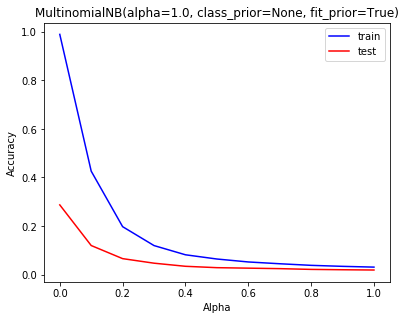

In [35]:
train_acc_uni, test_acc_uni, tune_param, clf_name = tune_clf(X_train, y_train, X_test, y_test, classifier="m_nb" )
plot_tune_clf( train_acc_uni, test_acc_uni, tune_param, clf_name )

In [42]:
train_acc_uni, test_acc_uni, tune_param, clf_name = tune_clf(X_train, y_train, X_test, y_test, classifier="logreg" )
plot_tune_clf( train_acc_uni, test_acc_uni, tune_param, clf_name )

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


1e-05 1.315 1.308
3.9810717055349695e-05 1.59 1.535
0.00015848931924611142 1.698 1.563


/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.000630957344480193 1.612 1.478


/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.0025118864315095794 1.662 1.507


/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.01 1.807 1.649


KeyboardInterrupt: 

### 3. Clustering

#### 3a. Data preparation

In [213]:
authormovements_df=pd.read_pickle("../2_Preprocessing/processeddata/df_pickle_movements/movements_df.pickle")

# let's randomly extract 10 authors and their movements
authormovements_df10 = authormovements_df.sample(n=100)

# let's get their filenames
datapath = "../2_Preprocessing/processeddata/df_pickles/{}_df.pickle"
df_filenames=[datapath.format(authornum) for authornum in authormovements_df10.index]
len(df_filenames)

100

In [214]:
# count unique literary movements
movements = []
for row in authormovements_df10["literarymovements"]:
    movements.extend([i for i in row])
    
movements = set(movements)
print(len(movements), "\n", movements)


110 
 {'historical novel', 'romantic fiction', 'medicine', 'realist literature', 'literary nonsense', 'journalism', 'naturalism', 'murder mystery', 'didactic poetry', 'crime fiction', 'anthologies', 'travel', 'socialist realism', 'natural history', "children's literature", 'fantasy literature', 'renaissance humanism', 'supernatural fiction', 'hellenistic literature', 'science fiction', 'english literature', 'adventure', 'time travel', 'history', 'mystery fiction', 'lds fiction', 'drama', 'mathematical logic', 'golden age of detective fiction', 'augustan literature', 'sword and planet', 'symbolism', 'dark fantasy', 'detective fiction', 'the song fishermen', 'planetary romance', 'sturm und drang', 'paranoid fiction', 'social sf', 'western', 'age of enlightenment', 'romanticism', 'new age', 'romance novel', 'soft science fiction', 'space opera', 'mystery', 'voting theory', 'lost world', 'short story', 'philosophical fiction', 'weird fiction', 'lyric poetry', 'scientific romance', 'augusta

In [215]:
# let's get their features

##### Preliminaries #####

# 1a. lists for collecting all the df objects to be generated for pd.concat - speediest approach 
# https://stackoverflow.com/questions/10715965/add-one-row-to-pandas-dataframe/24913075#24913075
dfs_list_train = [] 
dfs_list_test = []


# 1b. store author-label mapping
label2auth_map = {}
auth2label_map = {}


##### Processing #####
# 2. generate the master DF
label_counter = 1
for filename in df_filenames: 
    __ = pd.read_pickle(filename)
     
    authornum = __["authornum"][0]                             # get the authornum for this df   
                                
    label2auth_map[label_counter] = authornum                  # switch the authornum to int, store the mapping
    auth2label_map[authornum] = label_counter
    __["authornum"] = label_counter
    
    __ = __[__["sent_length"]>10]                               # filter out short sentences
    __["concreteness"] = __["concreteness"].astype(float)       # we set the concreteness score as a string 
                                                                # to run the process_one_author functions easily
                                                                # switch back to int here
    # get the subjectivity score for the author. 
    s_score = get_subjectivity(__["tokens"].values,subj_dict)[1]
    # add as a new column to this df
    __["subjectivity"]=s_score
    

    # train test split 
    __train, __test = train_test_split(__, test_size=0.20)
    dfs_list_train.append(__train)
    dfs_list_test.append(__test)
    
    label_counter += 1
    
_10author_df_train = pd.concat(dfs_list_train, axis=0)
_10author_df_test = pd.concat(dfs_list_test, axis=0)
_10author_df_train.reset_index(drop= True, inplace=True)
_10author_df_test.reset_index(drop= True, inplace=True)

print("train size: {}, test size: {}".format(_10author_df_train.shape, _10author_df_test.shape))

train size: (12102, 33), test size: (3079, 33)


In [216]:
__features = {"lemmas": 
                  {"train": _10author_df_train["lemmas"],
                    "test": _10author_df_test["lemmas"],},
              "namedentities": 
                  {"train": _10author_df_train['ne_dates']+_10author_df_train['ne_places'],
                   "test": _10author_df_test['ne_dates']+_10author_df_test['ne_places'],}, }
                # add the ne_dates and ne_places columns for the vectoriser to manage sparsity. leave out 
                # persons for now, it is possible person names can significantly identify authors (except 
                # perhaps authors) 
                          
for feat in __features:
    # train data - generate DictCounts
    token_Counters_train = []
    for row in __features[feat]["train"].index:
        token_Counters_train.append(collections.Counter(__features[feat]["train"][row]))
    
    # test data - generate DictCounts
    token_Counters_test = []
    for row in __features[feat]["test"].index:
        token_Counters_test.append(collections.Counter(__features[feat]["test"][row]))
    
    # transforming test set based on the train set fit 
    # pass the DictCounts into DictVectorizer() 
    Dvectoriser = DictVectorizer()
    Dvect_result_train = Dvectoriser.fit_transform(token_Counters_train)
    Dvect_result_test = Dvectoriser.transform(token_Counters_test)

    Ttransformer = TfidfTransformer()
    Ttrans_results_train = Ttransformer.fit_transform(Dvect_result_train)
    Ttrans_results_test = Ttransformer.transform(Dvect_result_test)
    
    # write to SVM
    dump_svmlight_file(Ttrans_results_train, _10author_df_train["authornum"], "data/clustering/train_"+feat+".svmlight")
    dump_svmlight_file(Ttrans_results_test, _10author_df_test["authornum"], "data/clustering/test_"+feat+".svmlight")
    
__other_features=['concreteness', 'subjectivity', "parse_VP"]
for feat in __other_features:
    # .reshapes since we are working with single feature sets each time 
    dump_svmlight_file(_10author_df_train[feat].values.reshape(-1,1),
                       _10author_df_train["authornum"], "data/clustering/train_"+feat+".svmlight")
    dump_svmlight_file(_10author_df_test[feat].values.reshape(-1,1), 
                       _10author_df_test["authornum"], "data/clustering/test_"+feat+".svmlight")        

In [217]:
def stack( A, B ):
    return hstack( [A,B] )

X_tr_lemmas, y_train, X_te_lemmas, y_test = load_data( "./data/clustering", features='lemmas')
X_tr_concreteness, y_train, X_te_concreteness, y_test = load_data( "./data/clustering", features='concreteness')
X_tr_namedentities, y_train, X_te_namedentities, y_test = load_data( "./data/clustering", features='namedentities')
X_tr_parse_VP, y_train, X_te_parse_VP, y_test = load_data( "./data/clustering", features='parse_VP')
X_tr_subjectivity, y_train, X_te_subjectivity, y_test = load_data( "./data/clustering", features='subjectivity')

X_train = hstack( [X_tr_subjectivity, X_tr_lemmas,X_tr_namedentities, X_tr_parse_VP] )
X_test = hstack( [X_te_subjectivity, X_te_lemmas, X_te_namedentities, X_te_parse_VP] )

In [218]:
X_train.shape

(12102, 24519)

In [219]:
X_test.shape

(3079, 24519)

##### 3b. Spectral clustering

Spectral clustering provides the most robust performance across different types of [clustering patterns](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py), since we have not been able to dimension reduce meaningfully to plot the distribution of our data (down to 2 or 3 principal component that have substantial explained variance), we don't have a clear idea of the distribution. So we pick spectral clustering as a start. 

In [220]:
spec_clust = SpectralClustering(n_clusters=10, n_init=10,n_neighbors=1)
spec_clust.fit(X_train)
y_train_pred = spec_clust.labels_

/Users/k1000mbp/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  n_init=n_init)


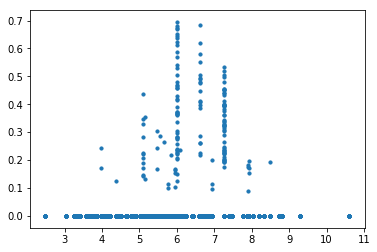

In [221]:
plt.scatter(X_train.toarray()[:, 0], X_train.toarray()[:, 1], s=10)